## Membership inference attack (MIA) on a BN

In [50]:
import random
import numpy as np
import math
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import norm

import pyagrum as gum
import pyagrum.lib.notebook as gnb

In [51]:
# Set seeds
random.seed(42)
gum.initRandom(seed=42)

In [52]:
# Init BN
bn=gum.fastBN("A[2]->B[3]")

# Plot BN
gnb.flow.row(bn, bn.cpt("A"), bn.cpt("B"), captions=["BN", "CPT (A)", "CPT (B|A)"])

In [53]:
# Set gpop, pool and rpop sample sizes
gpop_ss = 1000
ratio = 6

pool_ss = gpop_ss // ratio
rpop_ss = gpop_ss - pool_ss

assert(gpop_ss == pool_ss + rpop_ss)

In [54]:
# Generate data from BN
g = gum.BNDatabaseGenerator(bn)
g.drawSamples(gpop_ss)
g.setDiscretizedLabelModeRandom()

gpop = g.to_pandas()
pool_idx = np.random.choice(gpop_ss, replace=False, size=pool_ss)
pool = gpop.iloc[pool_idx]
rpop = gpop.iloc[~ gpop.index.isin(pool_idx)]

assert(gpop.shape[0]==gpop_ss)
assert(pool.shape[0]==pool_ss)
assert(rpop.shape[0]==rpop_ss)

In [55]:
# Learn BNs with theta and theta_hat
theta_learner=gum.BNLearner(rpop)
theta_hat_learner=gum.BNLearner(pool)

bn_theta = theta_learner.learnParameters(bn.dag())
bn_theta_hat = theta_hat_learner.learnParameters(bn.dag())

gnb.flow.row(bn, bn_theta.cpt("B"), bn_theta_hat.cpt("B"), captions=["Graph", "Theta_B", "Theta_hat_B"])

In [56]:
# Create objects for inference
bn_theta_ie = gum.LazyPropagation(bn_theta)
bn_theta_hat_ie = gum.LazyPropagation(bn_theta_hat)

In [57]:
# Define the log-likelihood ratio L(x)
def L(x: dict):

    # Erase all the evidences and apply addEvidence(key,value) for every pairs in x
    bn_theta_ie.setEvidence(x)
    assert(bn_theta_ie.nbrHardEvidence() == len(bn.nodes()))
    bn_theta_hat_ie.setEvidence(x)
    assert(bn_theta_hat_ie.nbrHardEvidence() == len(bn.nodes()))

    # Compute P(x | BN)
    L_theta = bn_theta_ie.evidenceProbability()
    L_theta_hat = bn_theta_hat_ie.evidenceProbability()

    # Erase all the evidences
    # bn_theta_ie.eraseAllEvidence()
    # bn_theta_hat_ie.eraseAllEvidence()

    return math.log(L_theta / L_theta_hat)

In [58]:
# Example
x = rpop.iloc[4]
x = x.to_dict()
print(f"L(x) = {L(x)}")

L(x) = 0.07009360660501483


(array([ 68.,   0.,   0.,   0., 262.,   0.,   0.,  97., 364.,  43.]),
 array([-0.33917689, -0.28515476, -0.23113264, -0.17711052, -0.12308839,
        -0.06906627, -0.01504414,  0.03897798,  0.0930001 ,  0.14702223,
         0.20104435]),
 <BarContainer object of 10 artists>)

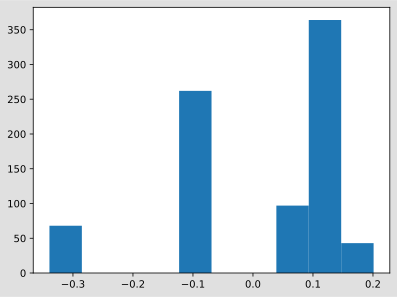

In [59]:
# Compute the distribution of L(x) under H_0, empirically on the reference population
L_im = rpop.apply(lambda x: L(x.to_dict()), axis=1)

# Plot the empirical distribution of L(x) under H_0
plt.hist(L_im)

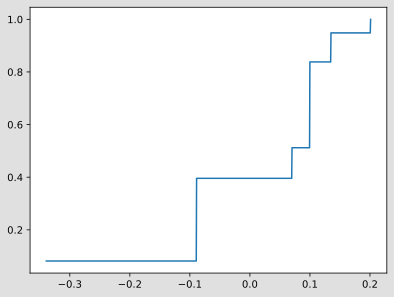

In [60]:
# Estimate the empirical CDF (ECDF) of L(x)
ecdf = ECDF(L_im)

# Plot the ECDF
p_x = np.linspace(min(L_im), max(L_im), 1000)
p_y = ecdf(p_x)
plt.plot(p_x, p_y, label="F(x)")

In [ ]:
# Given alpha, compute F^{-1}(alpha) i.e. the quantile of L(x) at level alpha. This is the threshold to be used in the test
alpha = 0.05
threshold = np.quantile(L_im, alpha).item()

print(f"Test threshold: {threshold}")

Test threshold: -0.33917688799253704


In [ ]:
# Define the test
def reject_H0(x: dict, t: float) -> bool:
    return L(x) < t

In [63]:
# Example
x = pool.iloc[4].to_dict()
reject_H0(x, threshold)

False

In [64]:
# Perform membership inference on whole general population
gpop["in-pool"] = False
gpop.loc[pool_idx, "in-pool"] = True
assert(sum(gpop["in-pool"] == True) == pool_ss)

gpop["in-pool-pred"] = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), threshold), axis=1)

In [65]:
# Confusion matrix
'''
C_{ij} means i, predicted as j

Predicted
 -----------
| TP  |  FN |
|-----------|
| FP  |  TN |
 -----------
 
'''


cm = confusion_matrix(gpop["in-pool"], gpop["in-pool-pred"], labels=[True, False], normalize='all')
tpr = cm[0,0]
fpr = cm[1,0]

cm

array([[0.   , 0.166],
       [0.   , 0.834]])

In [66]:
# Set threshold range
t_range = np.arange(-1e1, 1e1, 0.05)

# Init the error and power vectors
error = []
power = []

# For each threshold ...
for t in t_range:

    # Store the related error
    error = error + [ecdf(t)]

    # Perform LR test on whole population
    y_pred = gpop[[*bn.names()]].apply(lambda x: reject_H0(x.to_dict(), t), axis=1)

    # Compute and store power (tpr)
    cm = confusion_matrix(gpop["in-pool"], y_pred, labels=[True, False], normalize='all')
    tpr = cm[0,0]
    power = power + [tpr]


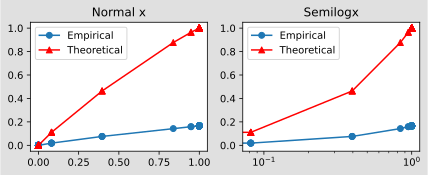

In [67]:
# Plot error vs power (empirical)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 7/3))
ax1.plot(error, power, "-o", label = 'Empirical')
ax2.semilogx(error, power, "-o", label = 'Empirical')

# Compute theoretical bound
bound = math.sqrt(bn.dim()/pool_ss)

# Find power (beta) for any error (alpha) given theoretical bound
z_alpha = [norm.ppf(1 - i).item() for i in error]
z_one_minus_beta = [bound - i for i in z_alpha]
beta = [norm.cdf(i).item() for i in z_one_minus_beta]

# Plot error vs power (theoretical)
ax1.plot(error, beta, "r-^", label = 'Theoretical')
ax2.semilogx(error, beta, "r-^", label = 'Theoretical')

# Plot info
ax1.set(title='Normal x')
ax2.set(title='Semilogx')

ax1.legend()
ax2.legend()
